In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import PowerTransformer

from xgboost import XGBRegressor
from jcopml.tuning import random_search_params as rsp
from jcopml.plot import plot_missing_value, plot_actual_vs_prediction, plot_residual

import pickle

%matplotlib inline

# Import Data

In [3]:
df = pd.read_csv("data/Cellphone.csv", index_col="Product_id")
df.head()

,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
Product_id,,,,,,,,,,,,,
203,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
880,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
40,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
99,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
880,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


### Check Missing Value

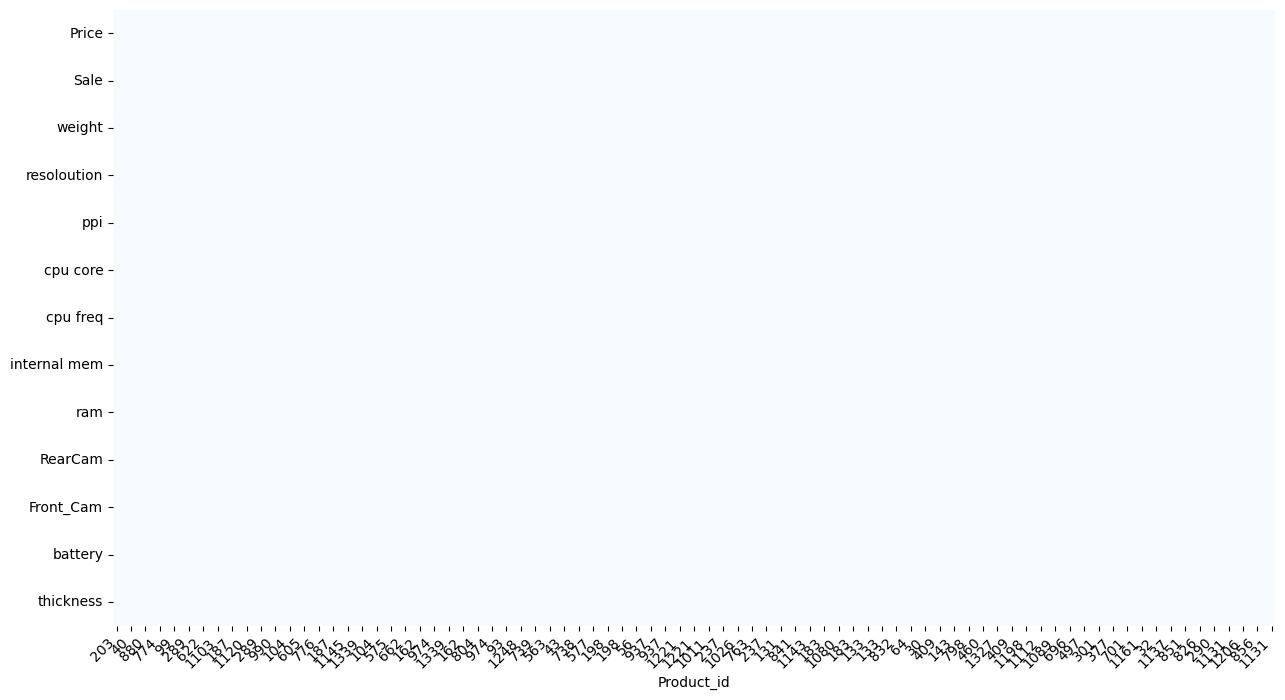

In [4]:
plot_missing_value(df)

### Check Duplicated Data

In [5]:
df.duplicated().sum()

0

### Info & Statistics

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 203 to 1131
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         161 non-null    int64  
 1   Sale          161 non-null    int64  
 2   weight        161 non-null    float64
 3   resoloution   161 non-null    float64
 4   ppi           161 non-null    int64  
 5   cpu core      161 non-null    int64  
 6   cpu freq      161 non-null    float64
 7   internal mem  161 non-null    float64
 8   ram           161 non-null    float64
 9   RearCam       161 non-null    float64
 10  Front_Cam     161 non-null    float64
 11  battery       161 non-null    int64  
 12  thickness     161 non-null    float64
dtypes: float64(8), int64(5)
memory usage: 21.7 KB


In [8]:
df.describe()

,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,2215.596273,621.465839,170.426087,5.209938,335.055901,4.857143,1.502832,24.501714,2.204994,10.378261,4.503106,2842.111801,8.921739
std,768.187171,1546.618517,92.888612,1.509953,134.826659,2.444016,0.599783,28.804773,1.609831,6.181585,4.342053,1366.990838,2.192564
min,614.000000,10.000000,66.000000,1.400000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,800.000000,5.100000
25%,1734.000000,37.000000,134.100000,4.800000,233.000000,4.000000,1.200000,8.000000,1.000000,5.000000,0.000000,2040.000000,7.600000
50%,2258.000000,106.000000,153.000000,5.150000,294.000000,4.000000,1.400000,16.000000,2.000000,12.000000,5.000000,2800.000000,8.400000
75%,2744.000000,382.000000,170.000000,5.500000,428.000000,8.000000,1.875000,32.000000,3.000000,16.000000,8.000000,3240.000000,9.800000
max,4361.000000,9807.000000,753.000000,12.200000,806.000000,8.000000,2.700000,128.000000,6.000000,23.000000,20.000000,9500.000000,18.500000


# Dataset Spliting

In [11]:
X = df.drop(columns="Price")
y = df.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Preprocessing

In [68]:
num_data = Pipeline([
    ("impute", SimpleImputer()),
    ("transform", PowerTransformer())
])

preprocessor = ColumnTransformer([
    ("numeric", num_data, X_train.columns)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBRegressor(n_jobs=-1, random_state=42))
])

In [79]:
params = rsp.xgb_params
params.update(({"prep__numeric__transform__method": ["yeo-johnson", "box-cox"]}))

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform'),
 'prep__numeric__transform__method': ['yeo-johnson', 'box-cox']}

# Training

In [81]:
reg = RandomizedSearchCV(pipeline, param_distributions=params, cv=3, verbose=1, 
                         random_state=42, n_iter=50)

reg.fit(X_train, y_train)
print(reg.best_params_)
print(reg.score(X_train, y_train), reg.score(X_test, y_test), reg.best_score_)

# Save Model
with open("model/xgb-reg-v3.pkl", "wb") as file:
    pickle.dump(reg, file)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\Nostics\miniconda3\envs\jcopml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
99 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
99 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nostics\miniconda3\envs\jcopml\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nostics\miniconda3\envs\jcopml\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Nostics\miniconda3\envs\jcopml\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transform

{'algo__colsample_bytree': 0.39285972834334104, 'algo__gamma': 4, 'algo__learning_rate': 0.054067659385040615, 'algo__max_depth': 8, 'algo__n_estimators': 106, 'algo__reg_alpha': 0.7651731056383421, 'algo__reg_lambda': 0.017070379153059048, 'algo__subsample': 0.5712701152774498, 'prep__numeric__transform__method': 'yeo-johnson'}
0.9997946758120221 0.9755424106027523 0.9678576291012929


# Evaluation

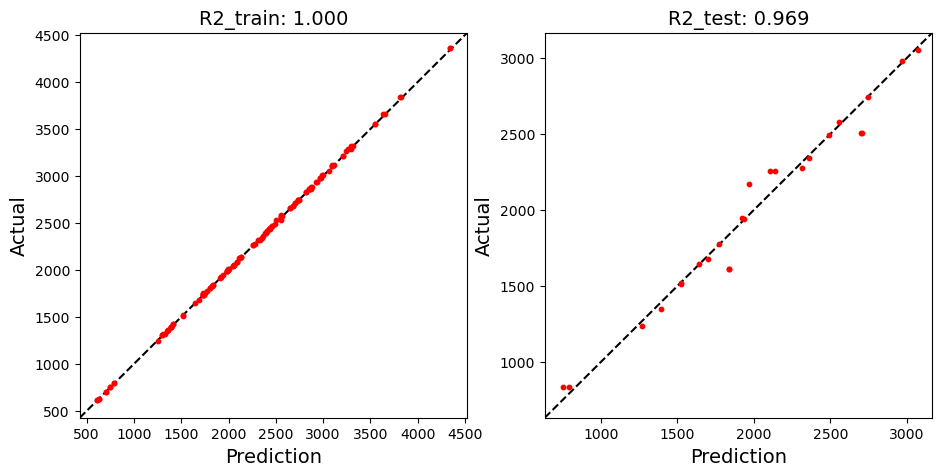

In [70]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, reg)

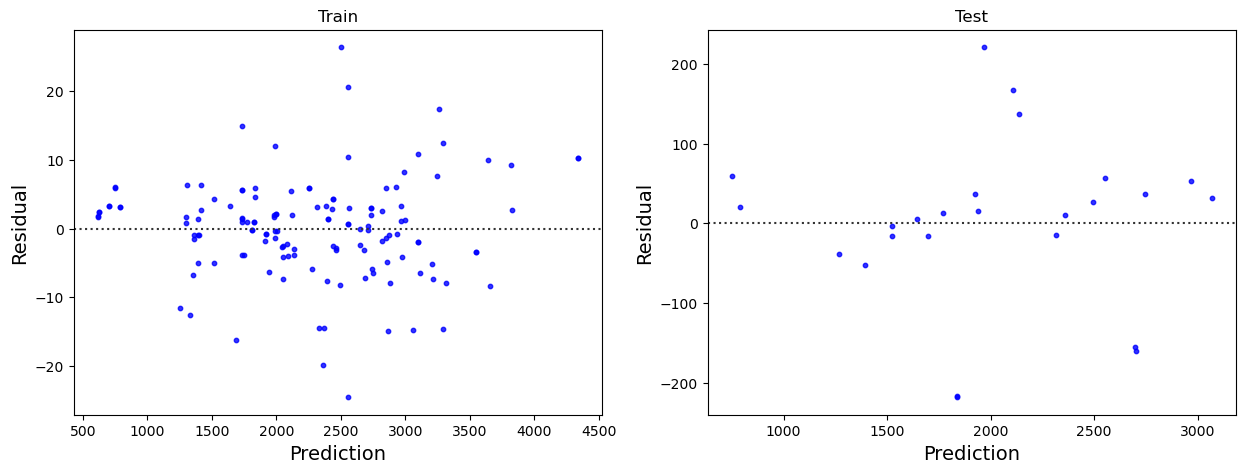

In [71]:
plot_residual(X_train, y_train, X_test, y_test, reg)

### Histogram

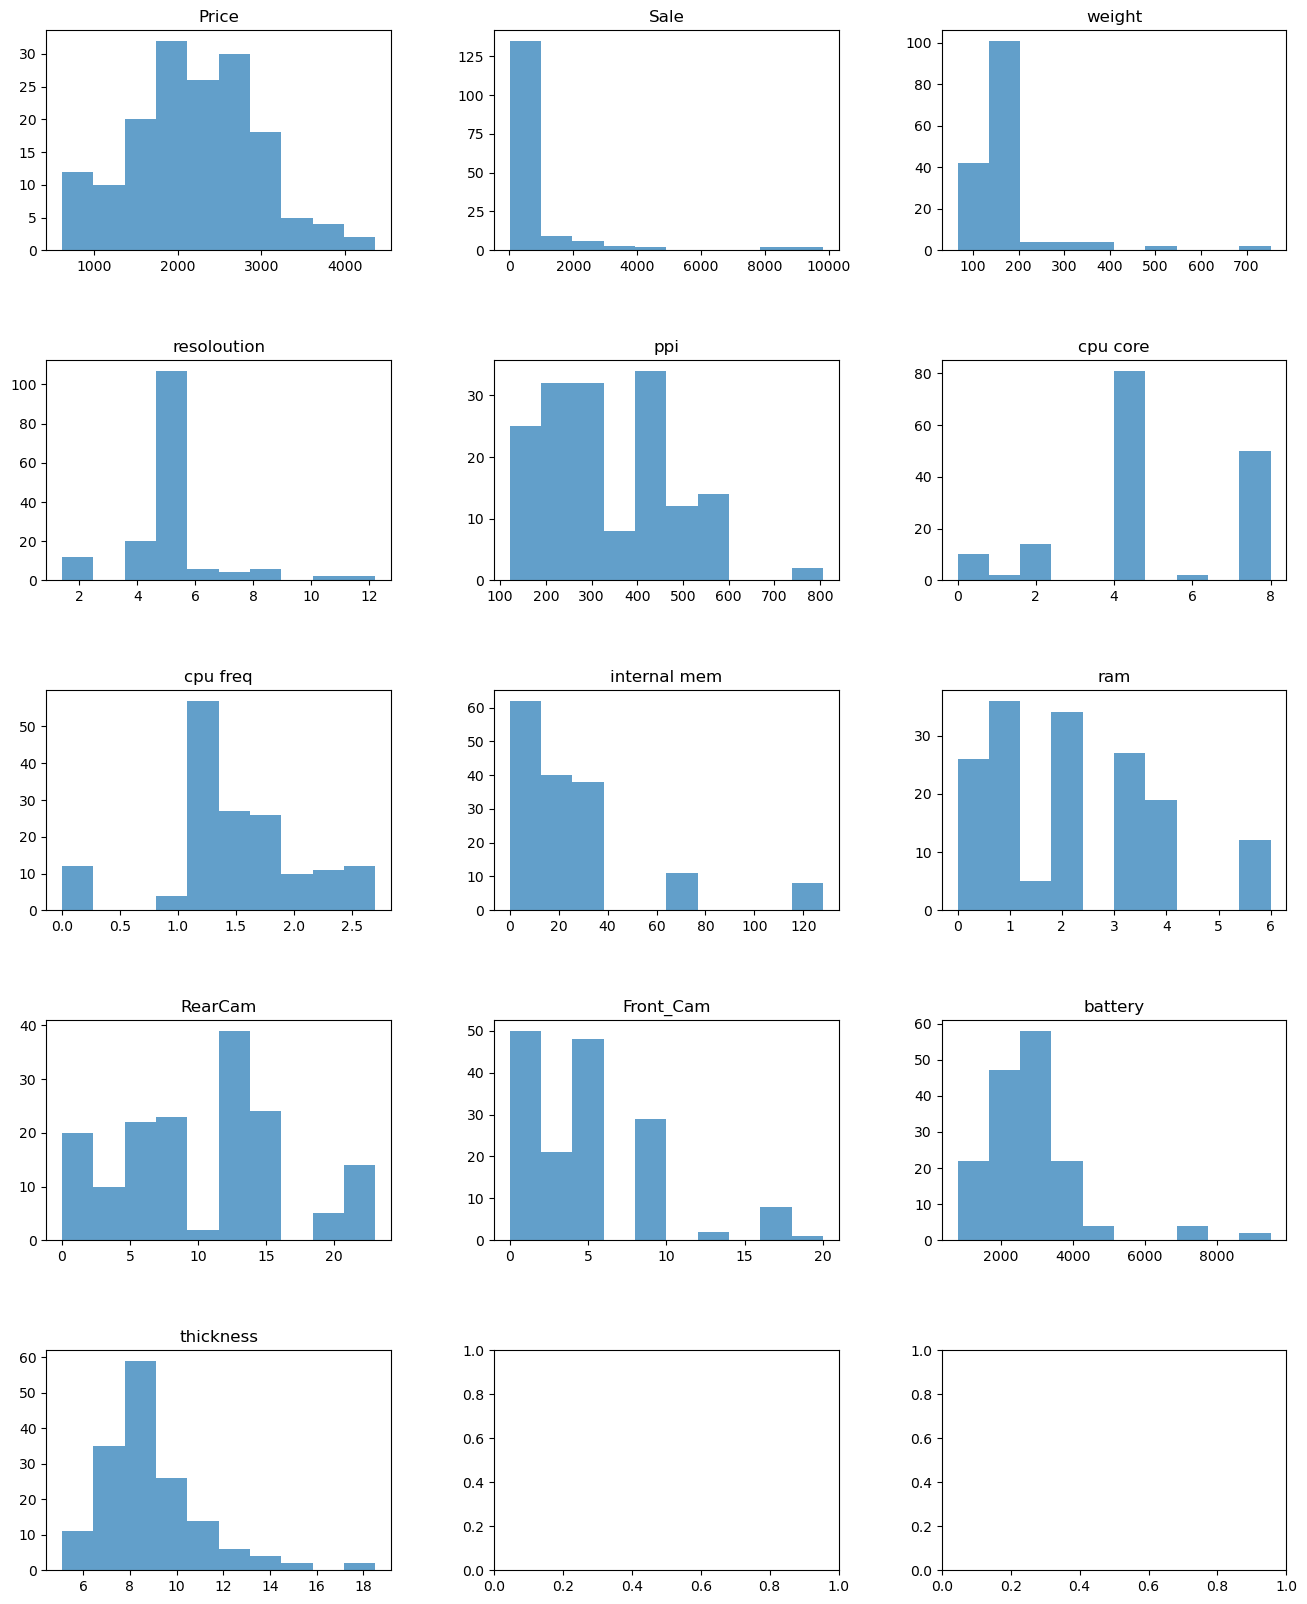

In [35]:
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(16,20))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

for col, ax in zip(df.columns, axes.flatten()):
    ax.hist(df[col], alpha=0.7)
    ax.set_title(col)

### Scatter plot

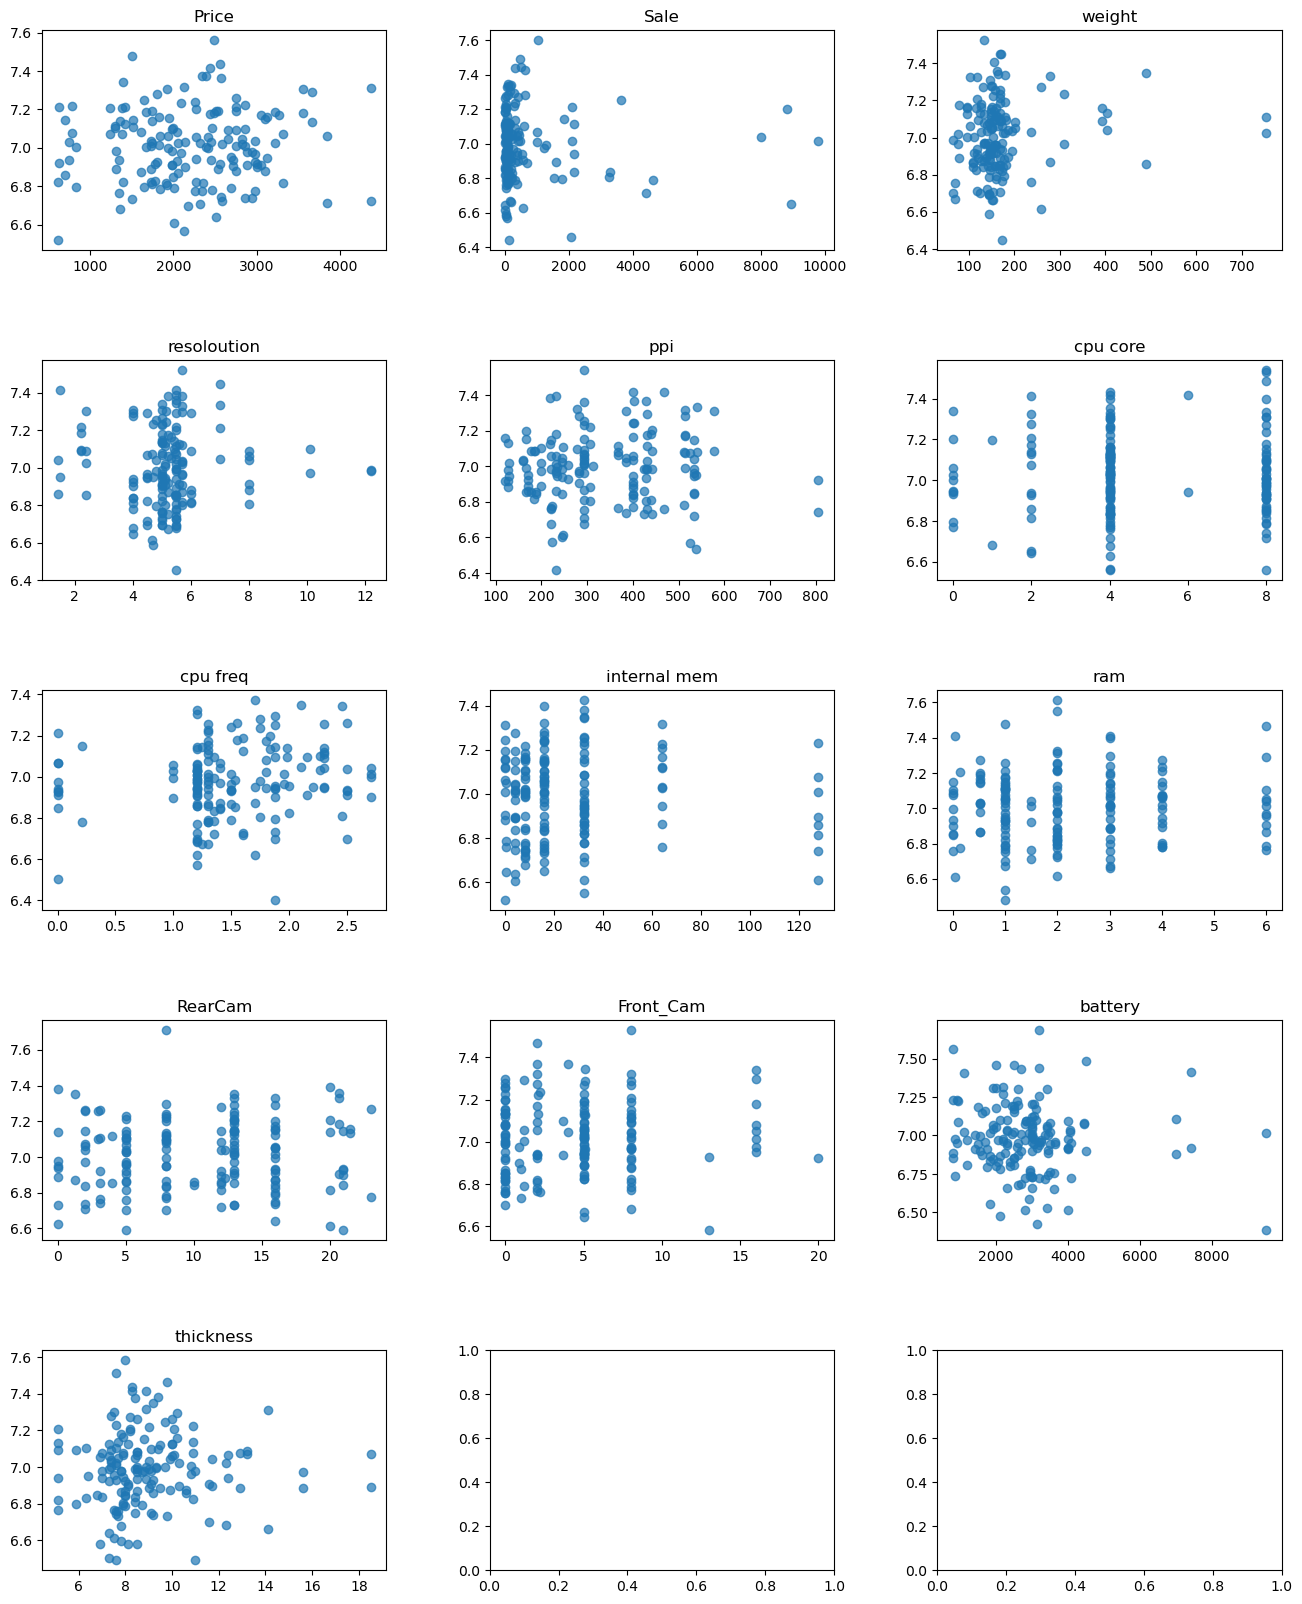

In [38]:
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(16,20))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

for col, ax in zip(df.columns, axes.flatten()):
    ax.scatter(df[col], np.random.normal(7, 0.2, size=df.shape[0]), alpha=0.7)
    ax.set_title(col)